In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'housedata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F46927%2F85203%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240511%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240511T121853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8df510b33af9e1016027ef1a2cedc7ecd08f7ef95409f9f77110bad6451670f5dd46c77a9da595fb977b74207560990e5fab12d5d4bd31611a70e4f4e9d3be9afae9ab97e16c811d0bf058f0617161b57065ffbab5ea2682d7a693a95d47df9721eb95a4ef8d3942cbe23a14ba571fcedbcc0290e03e79f1e859c1ad97f33b781b2b6fcba5b4204da9f9f57ede59908a63b8535e49cd83aeba8b2b9ccde59f6204f7ce399692b7b4c61bd603f03ff99058397b65d472c6705dab2d507aab8cdca08563d564c6fec4431eb4000a5aef2cf67c197b19e02702682e471e5084cc073dca07d4a0fcc99f343e5fe7d6d6720464004d400d230a01819a07d5c5a829fb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_squared_error , r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from category_encoders import MEstimateEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/housedata/output.csv
/kaggle/input/housedata/data.csv
/kaggle/input/housedata/data.dat


# EDA

In [ ]:
df= pd.read_csv('/kaggle/input/housedata/data.csv')
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


In [ ]:
df.shape

(4600, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [ ]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [ ]:
df.street.value_counts()

street
2520 Mulberry Walk NE     4
2500 Mulberry Walk NE     3
9413 34th Ave SW          2
6008 8th Ave NE           2
11034 NE 26th Pl          2
                         ..
1404 Broadmoor Dr E       1
3249 E Ames Lake Dr NE    1
6032 35th Ave NE          1
1006 NE Ravenna Blvd      1
18717 SE 258th St         1
Name: count, Length: 4525, dtype: int64

In [ ]:
df.city.value_counts()

city
Seattle                1573
Renton                  293
Bellevue                286
Redmond                 235
Issaquah                187
Kirkland                187
Kent                    185
Auburn                  176
Sammamish               175
Federal Way             148
Shoreline               123
Woodinville             115
Maple Valley             96
Mercer Island            86
Burien                   74
Snoqualmie               71
Kenmore                  66
Des Moines               58
North Bend               50
Covington                43
Duvall                   42
Lake Forest Park         36
Bothell                  33
Newcastle                33
SeaTac                   29
Tukwila                  29
Vashon                   29
Enumclaw                 28
Carnation                22
Normandy Park            18
Clyde Hill               11
Medina                   11
Fall City                11
Black Diamond             9
Ravensdale                7
Pacific        

In [ ]:
df.country.value_counts()

country
USA    4600
Name: count, dtype: int64

In [ ]:
df.statezip.value_counts()

statezip
WA 98103    148
WA 98052    135
WA 98117    132
WA 98115    130
WA 98006    110
           ... 
WA 98047      6
WA 98288      3
WA 98050      2
WA 98354      2
WA 98068      1
Name: count, Length: 77, dtype: int64

In [ ]:
df.waterfront.value_counts()

waterfront
0    4567
1      33
Name: count, dtype: int64

In [ ]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [ ]:
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [ ]:
df.duplicated().sum()

0

<Axes: xlabel='city'>

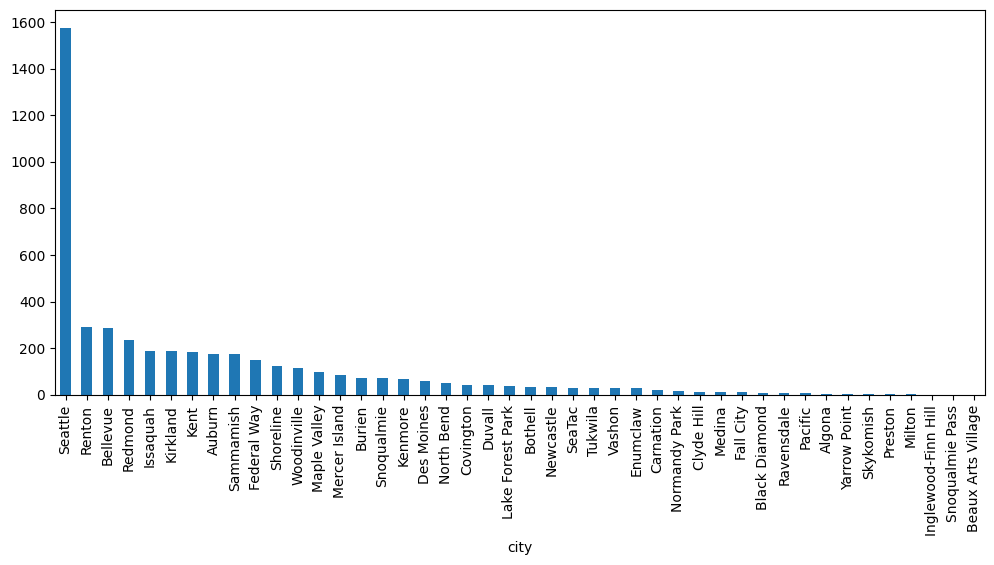

In [ ]:
df.city.value_counts().plot(kind='bar', figsize=(12,5))

<Axes: xlabel='city'>

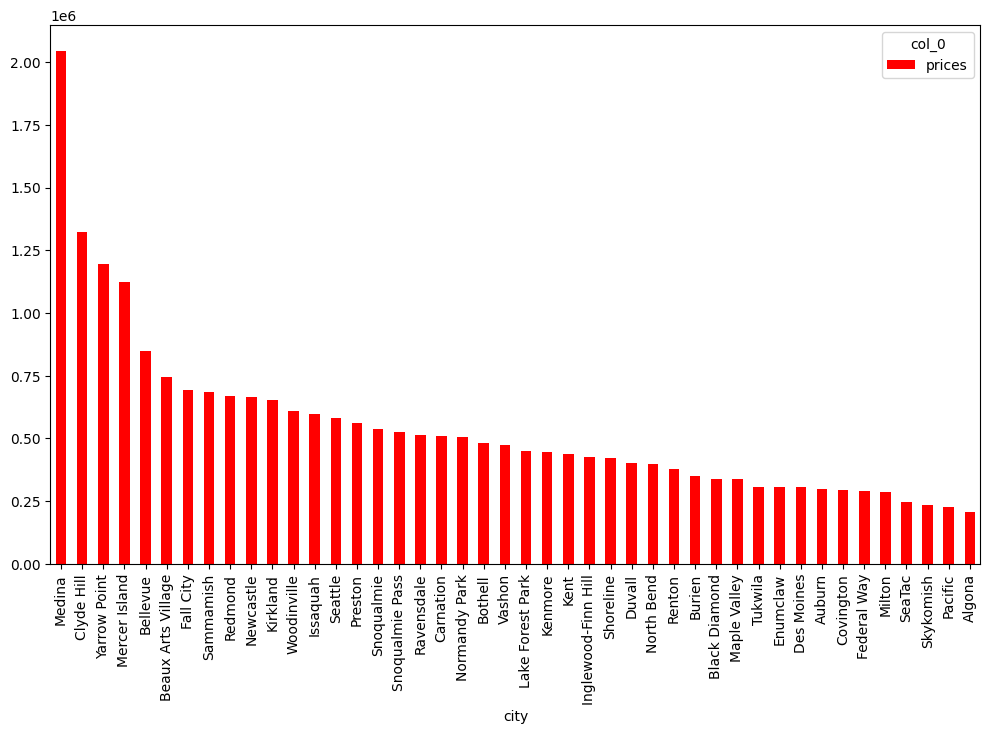

In [ ]:
pd.crosstab(index = df.city , columns = "prices" , values = df.price , aggfunc = "mean").sort_values(ascending  = False , by = "prices").plot(kind = "bar" , figsize = (12,7) , color = "r")

<Axes: xlabel='condition'>

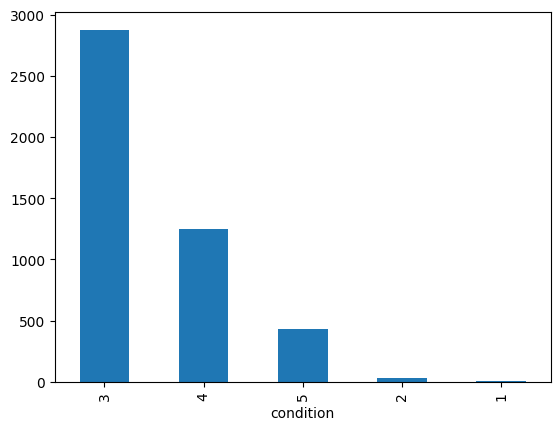

In [ ]:
df.condition.value_counts().plot(kind="bar")

In [ ]:
top_5_prices = df['price'].head(5)
fig = px.pie(values=top_5_prices, names=top_5_prices.index, title="Top 5 Prices")
fig.show()

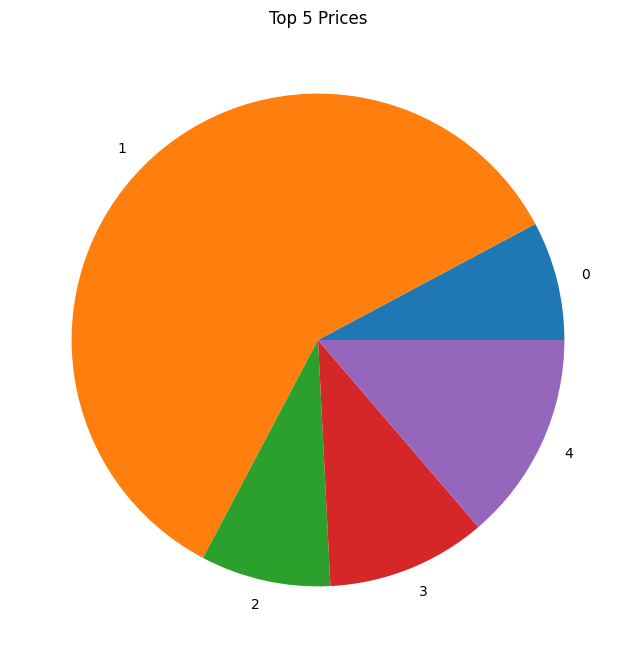

In [ ]:
names = top_5_prices.index
plt.figure(figsize=(8, 8))
plt.pie(top_5_prices, labels=names)
plt.title("Top 5 Prices")
plt.show()

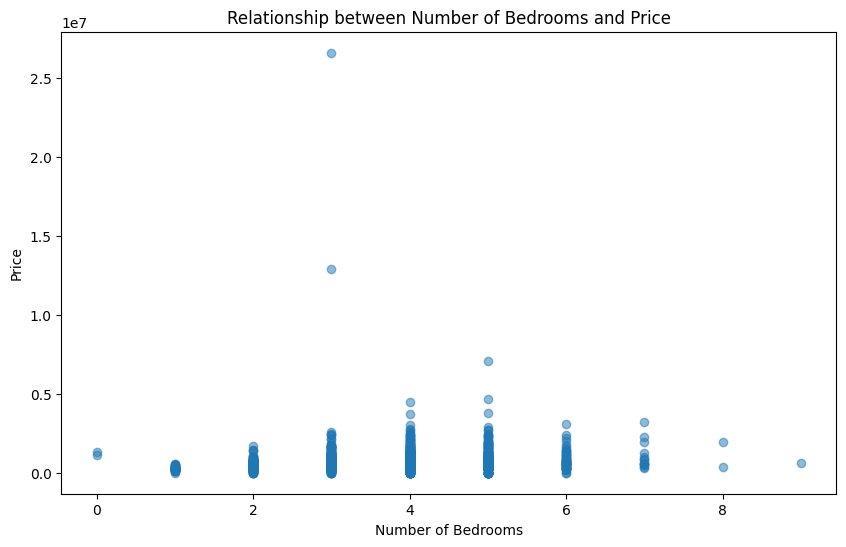

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['bedrooms'], df['price'], alpha=0.5)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.title('Relationship between Number of Bedrooms and Price')
plt.show()

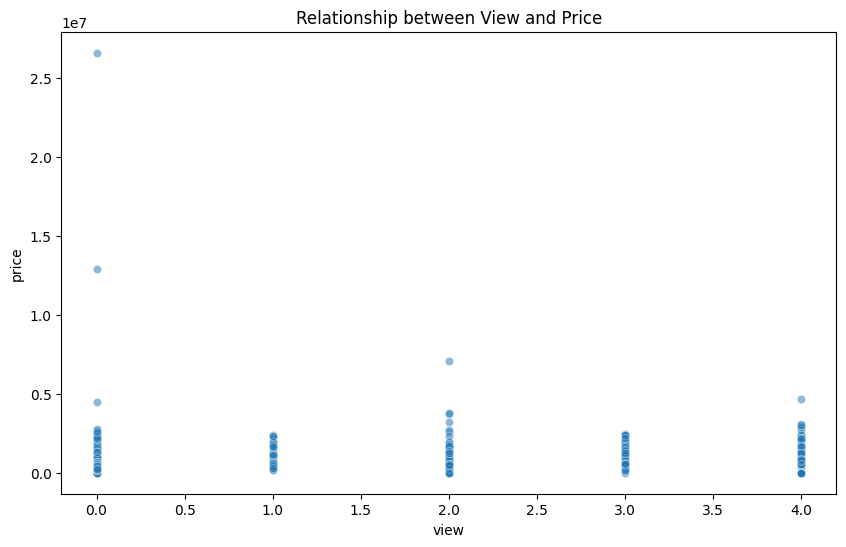

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='view', y='price', data=df, alpha=0.5)
plt.title('Relationship between View and Price')
plt.show()

In [ ]:
df.head(1)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA


In [ ]:
df[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','sqft_above','sqft_basement','yr_built','yr_renovated']].corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
price,1.000000,0.200336,0.327110,0.430410,0.050451,0.151461,0.135648,0.228504,0.034915,0.367570,0.210427,0.021857,-0.028774
bedrooms,0.200336,1.000000,0.545920,0.594884,0.068819,0.177895,-0.003483,0.111028,0.025080,0.484705,0.334165,0.142461,-0.061082
bathrooms,0.327110,0.545920,1.000000,0.761154,0.107837,0.486428,0.076232,0.211960,-0.119994,0.689918,0.298020,0.463498,-0.215886
sqft_living,0.430410,0.594884,0.761154,1.000000,0.210538,0.344850,0.117616,0.311009,-0.062826,0.876443,0.447206,0.287775,-0.122817
sqft_lot,0.050451,0.068819,0.107837,0.210538,1.000000,0.003750,0.017241,0.073907,0.000558,0.216455,0.034842,0.050706,-0.022730
floors,0.151461,0.177895,0.486428,0.344850,0.003750,1.000000,0.022024,0.031211,-0.275013,0.522814,-0.255510,0.467481,-0.233996
waterfront,0.135648,-0.003483,0.076232,0.117616,0.017241,0.022024,1.000000,0.360935,0.000352,0.078911,0.097501,-0.023563,0.008625
view,0.228504,0.111028,0.211960,0.311009,0.073907,0.031211,0.360935,1.000000,0.063077,0.174327,0.321602,-0.064465,0.022967
condition,0.034915,0.025080,-0.119994,-0.062826,0.000558,-0.275013,0.000352,0.063077,1.000000,-0.178196,0.200632,-0.399698,-0.186818
sqft_above,0.367570,0.484705,0.689918,0.876443,0.216455,0.522814,0.078911,0.174327,-0.178196,1.000000,-0.038723,0.408535,-0.160426


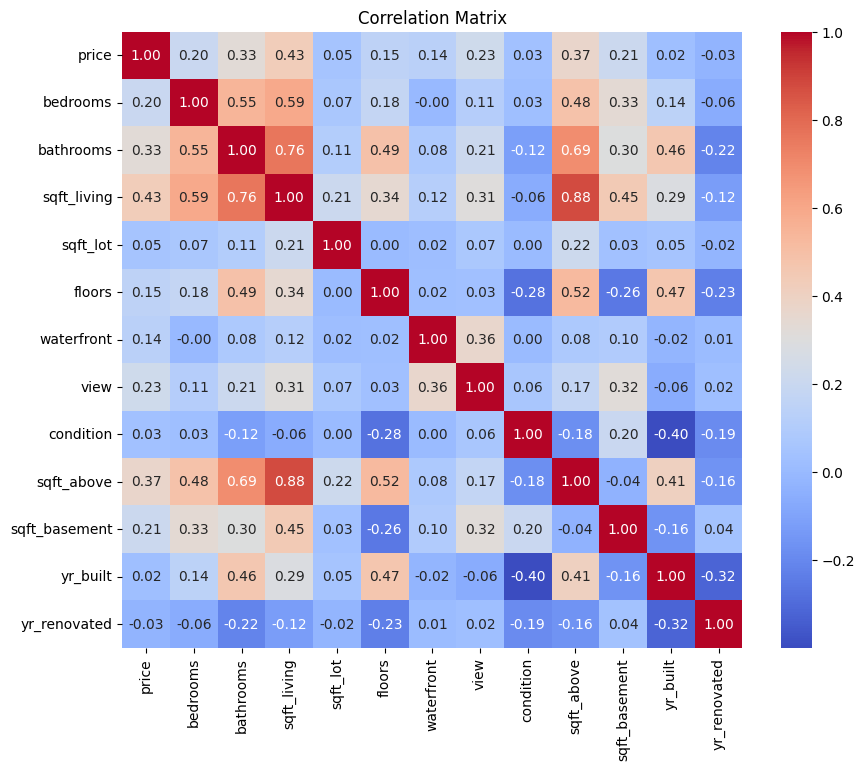

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['age'] = df['date'].dt.year - df['yr_built']
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,age
0,2014-05-02,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,59
1,2014-05-02,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA,93
2,2014-05-02,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,48
3,2014-05-02,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,51
4,2014-05-02,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,38


In [ ]:
#label=LabelEncoder()
#df['street']=label.fit_transform(df['street'])
#df['city']=label.fit_transform(df['city'])
#df['statezip']=label.fit_transform(df['statezip'])
#df

In [ ]:
df= df.drop(['date','yr_built','country'], axis=1)
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_renovated,street,city,statezip,age
0,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,2005,18810 Densmore Ave N,Shoreline,WA 98133,59
1,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,0,709 W Blaine St,Seattle,WA 98119,93
2,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,0,26206-26214 143rd Ave SE,Kent,WA 98042,48
3,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,0,857 170th Pl NE,Bellevue,WA 98008,51
4,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1992,9105 170th Ave NE,Redmond,WA 98052,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1979,501 N 143rd St,Seattle,WA 98133,60
4596,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,2009,14855 SE 10th Pl,Bellevue,WA 98007,31
4597,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,0,759 Ilwaco Pl NE,Renton,WA 98059,5
4598,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,0,5148 S Creston St,Seattle,WA 98178,40


In [ ]:
X= df.drop('price', axis= 'columns')
y=df.price

In [ ]:
X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_renovated,street,city,statezip,age
0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,2005,18810 Densmore Ave N,Shoreline,WA 98133,59
1,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,0,709 W Blaine St,Seattle,WA 98119,93
2,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,0,26206-26214 143rd Ave SE,Kent,WA 98042,48
3,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,0,857 170th Pl NE,Bellevue,WA 98008,51
4,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1992,9105 170th Ave NE,Redmond,WA 98052,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1979,501 N 143rd St,Seattle,WA 98133,60
4596,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,2009,14855 SE 10th Pl,Bellevue,WA 98007,31
4597,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,0,759 Ilwaco Pl NE,Renton,WA 98059,5
4598,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,0,5148 S Creston St,Seattle,WA 98178,40


In [ ]:
y

0       3.130000e+05
1       2.384000e+06
2       3.420000e+05
3       4.200000e+05
4       5.500000e+05
            ...     
4595    3.081667e+05
4596    5.343333e+05
4597    4.169042e+05
4598    2.034000e+05
4599    2.206000e+05
Name: price, Length: 4600, dtype: float64

In [ ]:
df = df[['street', 'statezip', 'city', 'sqft_living', 'sqft_above', 'bathrooms', 'sqft_lot']]
df

,street,statezip,city,sqft_living,sqft_above,bathrooms,sqft_lot
0,18810 Densmore Ave N,WA 98133,Shoreline,1340,1340,1.50,7912
1,709 W Blaine St,WA 98119,Seattle,3650,3370,2.50,9050
2,26206-26214 143rd Ave SE,WA 98042,Kent,1930,1930,2.00,11947
3,857 170th Pl NE,WA 98008,Bellevue,2000,1000,2.25,8030
4,9105 170th Ave NE,WA 98052,Redmond,1940,1140,2.50,10500
...,...,...,...,...,...,...,...
4595,501 N 143rd St,WA 98133,Seattle,1510,1510,1.75,6360
4596,14855 SE 10th Pl,WA 98007,Bellevue,1460,1460,2.50,7573
4597,759 Ilwaco Pl NE,WA 98059,Renton,3010,3010,2.50,7014
4598,5148 S Creston St,WA 98178,Seattle,2090,1070,2.00,6630


In [ ]:
df.join(y)

,street,statezip,city,sqft_living,sqft_above,bathrooms,sqft_lot,price
0,18810 Densmore Ave N,WA 98133,Shoreline,1340,1340,1.50,7912,3.130000e+05
1,709 W Blaine St,WA 98119,Seattle,3650,3370,2.50,9050,2.384000e+06
2,26206-26214 143rd Ave SE,WA 98042,Kent,1930,1930,2.00,11947,3.420000e+05
3,857 170th Pl NE,WA 98008,Bellevue,2000,1000,2.25,8030,4.200000e+05
4,9105 170th Ave NE,WA 98052,Redmond,1940,1140,2.50,10500,5.500000e+05
...,...,...,...,...,...,...,...,...
4595,501 N 143rd St,WA 98133,Seattle,1510,1510,1.75,6360,3.081667e+05
4596,14855 SE 10th Pl,WA 98007,Bellevue,1460,1460,2.50,7573,5.343333e+05
4597,759 Ilwaco Pl NE,WA 98059,Renton,3010,3010,2.50,7014,4.169042e+05
4598,5148 S Creston St,WA 98178,Seattle,2090,1070,2.00,6630,2.034000e+05


In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [ ]:
encoder = MEstimateEncoder(cols=['street','statezip','city'], m=0.5)

X = encoder.fit_transform(X, y)

In [ ]:
X

,street,statezip,city,sqft_living,sqft_above,bathrooms
0,10225.505362,6862.879765,9125.645814,1340,1340,1.50
1,10984.172029,4278.086021,5329.652531,3650,3370,2.50
2,12915.505362,18250.092120,15156.103817,1930,1930,2.00
3,10304.172029,10533.153625,13743.117829,2000,1000,2.25
4,11950.838696,11315.212236,23916.905554,1940,1140,2.50
...,...,...,...,...,...,...
4595,9190.838696,6862.879765,5329.652531,1510,1510,1.75
4596,9999.505362,13647.348305,13743.117829,1460,1460,2.50
4597,9626.838696,15887.091625,14556.419959,3010,3010,2.50
4598,9370.838696,8715.318344,5329.652531,2090,1070,2.00


In [ ]:
y

0        7912
1        9050
2       11947
3        8030
4       10500
        ...  
4595     6360
4596     7573
4597     7014
4598     6630
4599     8102
Name: sqft_lot, Length: 4600, dtype: int64

# Modeling

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 ,random_state=42 ,shuffle=True)

In [ ]:
model_lr= LinearRegression()
model_lr.fit(X_train,y_train)

LinearRegression()

In [ ]:
model_lr.score(X_train,y_train)

0.9997857446199248

In [ ]:
model_lr.score(X_test,y_test)

0.9998576281087558

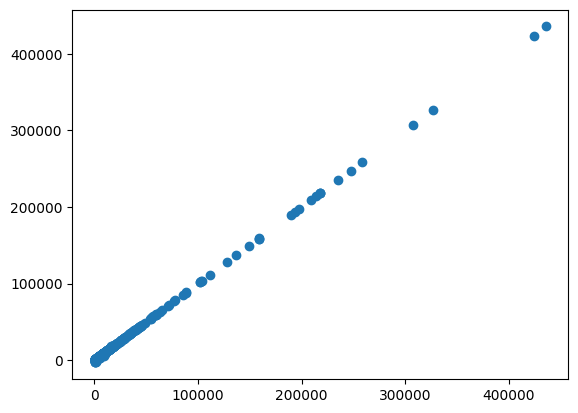

In [ ]:
predictions = model_lr.predict(X_test)
plt.scatter(y_test, predictions)

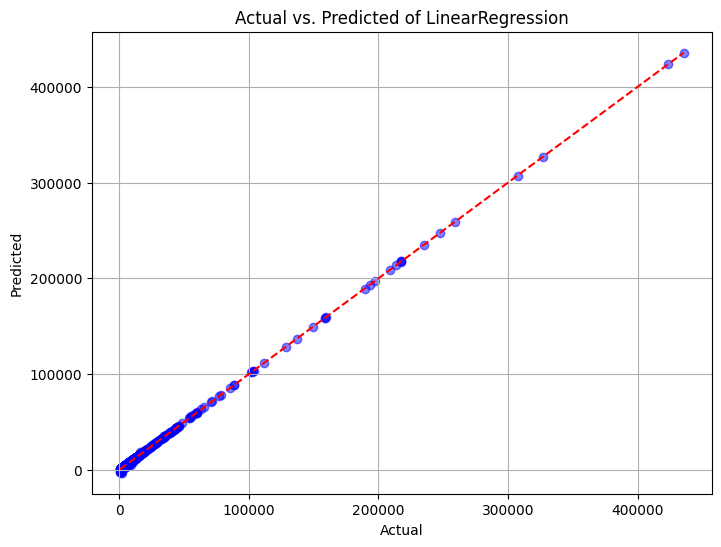

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted of LinearRegression')
plt.grid(True)
plt.show()

In [ ]:
cvs = cross_val_score(model_lr, X_train, y_train, cv=10, n_jobs=-1)
print('Accuracy: {:.2f} %'.format(cvs.mean() * 100))

Accuracy: 99.97 %


In [ ]:
model_rf = RandomForestRegressor(n_estimators = 400)
model_rf.fit(X_train , y_train)

RandomForestRegressor(n_estimators=400)

In [ ]:
model_rf.score(X_train,y_train)

0.9900618501626626

In [ ]:
model_rf.score(X_test,y_test)

0.9967608183160237

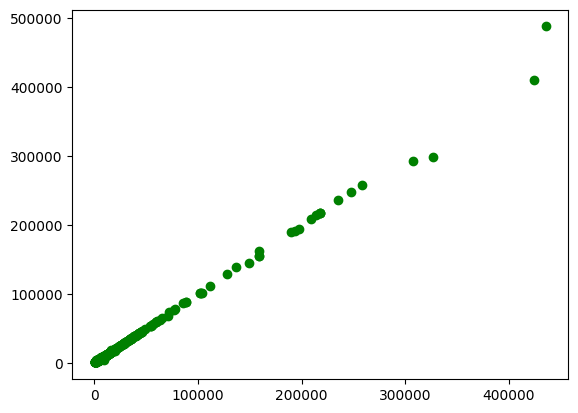

In [ ]:
predictions = model_rf.predict(X_test)
plt.scatter(y_test, predictions, color='g')

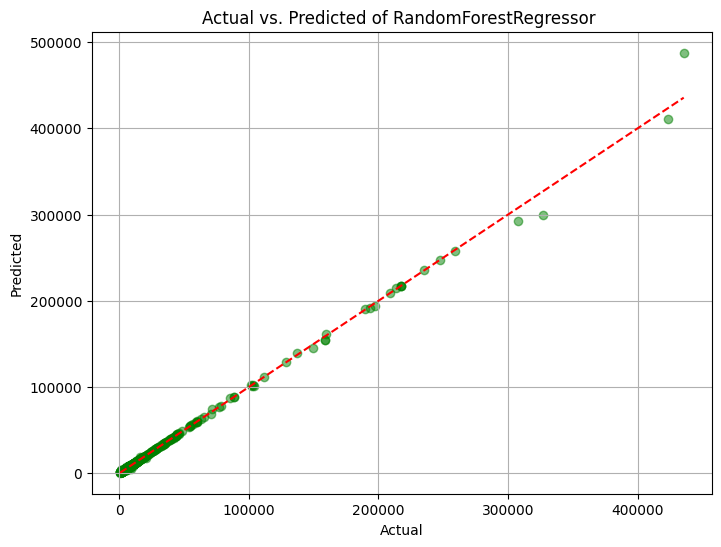

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='g', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted of RandomForestRegressor ')
plt.grid(True)
plt.show()

In [ ]:
cvs = cross_val_score(model_rf, X_train, y_train, cv=10, n_jobs=-1)
print('Accuracy: {:.2f} %'.format(cvs.mean() * 100))

Accuracy: 96.68 %


In [ ]:
model_dt =DecisionTreeRegressor(splitter  = "random")
model_dt.fit(X_train , y_train)

DecisionTreeRegressor(splitter='random')

In [ ]:
model_dt.score(X_train,y_train)

0.9999999412285255

In [ ]:
model_dt.score(X_test,y_test)

0.998239542710673

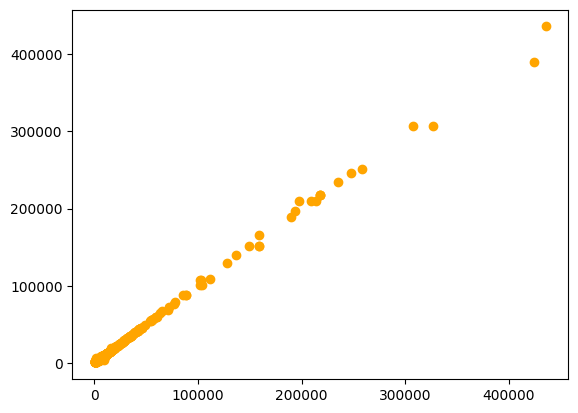

In [ ]:
predictions = model_dt.predict(X_test)
plt.scatter(y_test, predictions, color='orange')

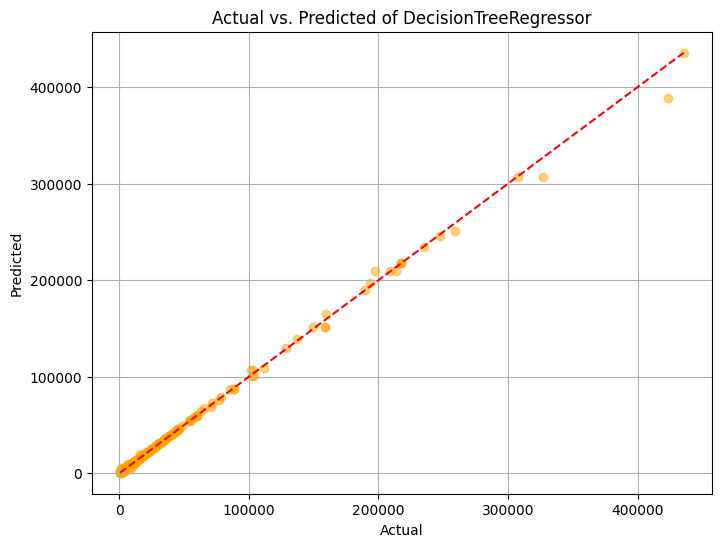

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='orange', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted of DecisionTreeRegressor')
plt.grid(True)
plt.show()

In [ ]:
cvs = cross_val_score(model_dt, X_train, y_train, cv=10, n_jobs=-1)
print('Accuracy: {:.2f} %'.format(cvs.mean() * 100))

Accuracy: 96.84 %


In [ ]:
df = pd.DataFrame(columns=['Model', 'Accuracy'])
model_names = ["LinearRegression", "Random Forest", "DecisionTree"]
accuracies = [99.97, 96.65, 95.79]

new_data = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies})
df = pd.concat([df, new_data], ignore_index=True)

df

,Model,Accuracy
0,LinearRegression,99.97
1,Random Forest,96.65
2,DecisionTree,95.79


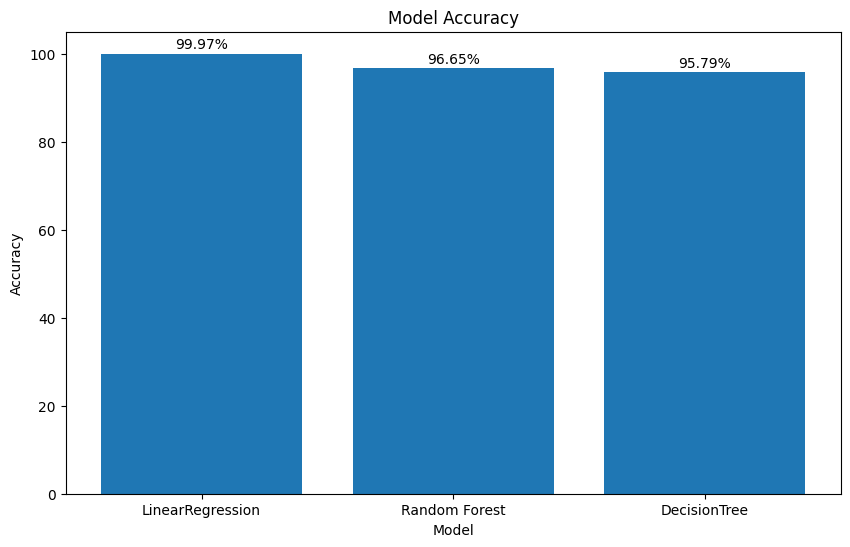

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{acc}%', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()